Thanks to Taichi Graphics

Tutorial: https://github.com/chunleili/tiPBD

##### (X)PBD ((Extendend) Position based dynamics)
- initialize all vertices $v_i$
- while true
    - $v_i=v_i+\Delta t (f_i/m_i)$
    - apply damping
    - $p_i=x_i+v_i\Delta t$
    - $p_i\ = p_i+\Delta p = p_i-\frac{s_{ij}}{m_i}\nabla_{p_i}C_j(p_1,\ldots,p_i,\ldots)$
    - $v_i = (p_i-x_i)/\Delta t$ (this is why it's position based)
    - $x_i = p_i$


$s_{ij} = \frac{C_j}{\sum_k \frac{1}{m_k}|\nabla_{p_k} C_j|^2+\alpha}$, $\alpha=\frac{c}{(\Delta t^2)}$, $c$ is compliance.
If $c=0$, XPBD becomes PBD

Like Newton's law on position, unphysical but stable

useful for games or movies

Constraints

- spring
    - $C(p_1,p_2)=|p_1-p_2|-d$
    - $\nabla_{p_1}C=\frac{p_1-p_2}{|p_1-p_2|}$
    - $\nabla_{p_2}C=-\frac{p_1-p_2}{|p_1-p_2|}$
- tetrahedral
    - 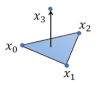
    - $C=6(V-V_0)$
    - $V = |\frac{1}{6}[(x_1-x_0)\times(x_2-x_0)]\cdot(x_3-x_0)$
    - Gradient of a vertex is a normal away from opposite plane
    - $\nabla_{x_0}C=(x_3-x_1)\times(x_2-x_1)$
    - $\nabla_{x_1}C=(x_2-x_0)\times(x_3-x_0)$
    - $\nabla_{x_2}C=(x_3-x_0)\times(x_1-x_0)$
    - $\nabla_{x_3}C=(x_1-x_0)\times(x_2-x_0)$

##### Controls

<kbd>k</kbd>  add upward impulse

<kbd>l</kbd>  drag bunny towards origin

<kbd>Esc</kbd>  exit program

In [1]:
import taichi as ti
import taichi.math as tm
from tiReadMesh import *

[Taichi] version 1.7.3, llvm 15.0.1, commit 5ec301be, win, python 3.9.21
[Taichi] Starting on arch=x64


In [2]:
numSubsteps = 10
dt = 1.0 / 60.0 / numSubsteps
edgeCompliance = 100.0
volumeCompliance = 0.0

lastPos = ti.Vector.field(3, float, numParticles)
vel = ti.Vector.field(3, float, numParticles)

surf_show = ti.field(int, numSurfs * 3)
surf_show.from_numpy(surf_np.flatten())

In [3]:
floor_height = 0
coef_restitution = 0.4

@ti.kernel
def preSolve(floor_height : float, random_force_index : int, random_force : float, central_force : bool):
    g = tm.vec3(0,-1,0)
    for i in range(numParticles):
        lastPos[i] = pos[i]
        vel[i] += g * dt
        if i == random_force_index:
            if central_force:
                vel[i] += (tm.vec3(0,0,0) - pos[i])*random_force*invMass[i] * dt
            else:
                vel[i] += -g*random_force*invMass[i] * dt
        pos[i] += vel[i] * dt
        if pos[i].y < floor_height:
            # no slip condition
            pos[i] = lastPos[i]
            pos[i].y *= -coef_restitution

In [4]:
@ti.kernel
def solveEdge():
    alpha = edgeCompliance/dt/dt
    grads = tm.vec3(0,0,0)
    for i in range(numEdges):
        i0 = edge[i][0]
        i1 = edge[i][1]

        grads = pos[i0] - pos[i1]
        Len = grads.norm()
        grads /= Len
        C = Len - restLen[i]
        s = -C / (invMass[i0]+invMass[i1] + alpha) # |grad C|^2=1
        
        pos[i0] += grads*s*invMass[i0]
        pos[i1] += -grads*s*invMass[i1]

@ti.kernel
def solveVolume():
    alpha = volumeCompliance /dt/ dt
    grads = [tm.vec3(0,0,0), tm.vec3(0,0,0), tm.vec3(0,0,0), tm.vec3(0,0,0)]

    for i in range(numTets):
        id = tm.ivec4(-1,-1,-1,-1) # pythonic declare
        for j in ti.static(range(4)):
            id[j] = tet[i][j]
        grads[0] = (pos[id[3]] - pos[id[1]]).cross(pos[id[2]] - pos[id[1]])
        grads[1] = (pos[id[2]] - pos[id[0]]).cross(pos[id[3]] - pos[id[0]])
        grads[2] = (pos[id[3]] - pos[id[0]]).cross(pos[id[1]] - pos[id[0]])
        grads[3] = (pos[id[1]] - pos[id[0]]).cross(pos[id[2]] - pos[id[0]])
        w = 0.0
        for j in ti.static(range(4)):
            w += invMass[id[j]] * (grads[j].norm())**2
        vol = tetVolume(i)
        C = (vol-restVol[i]) * 6.0
        s = -C/(w+alpha)

        for j in ti.static(range(4)):
            pos[tet[i][j]] += grads[j]*s*invMass[id[j]]

def solve():
    solveEdge()
    solveVolume()

In [5]:
@ti.kernel
def postSolve():
    for i in pos:
        vel[i] = (pos[i]-lastPos[i]) / dt

def substep(random_force_index, random_force, bCentralForce):
    preSolve(floor_height, random_force_index, random_force, bCentralForce)
    solve()
    postSolve()

In [6]:
@ti.kernel
def init_pos():
    for i in range(numParticles):
        pos[i] += tm.vec3(0.5,1,0)

init_pos()

In [7]:
window = ti.ui.Window("pbd", (1024,1024), vsync=True)
gui = window.get_gui()
canvas = window.get_canvas()
scene = ti.ui.Scene()
camera = ti.ui.make_camera()

#initial camera position
camera.position(4.0, 3.0, 4.0)
camera.lookat(0.5, 2, 0.5)
camera.fov(55)

frame = 0
PI_3 = tm.pi/3
TAU_3 = tm.pi*2/3
floor_mesh = ti.Vector.field(3,float,4)
floor_size = 1
floor_mesh[0][0] = -floor_size
floor_mesh[0][2] = -floor_size
floor_mesh[1][0] = -floor_size
floor_mesh[1][2] = floor_size
floor_mesh[2][0] = floor_size
floor_mesh[2][2] = floor_size
floor_mesh[3][0] = floor_size
floor_mesh[3][2] = -floor_size
floor_surf = ti.field(int,6)
floor_surf.from_numpy(np.array([0,1,2,2,3,0]))

from random import randint

force_vert_index = -1
force = 0.0
bCentralForce = False

save_image = False

text_top_left = ''
text_num_frames = 20
text_num_frames_left = 0
gui.sub_window("asdf", x=100, y=10, width=40, height=30)

while window.running:
    frame += 1
    #do the simulation in each step
    for _ in range(numSubsteps):
        substep(force_vert_index, force, bCentralForce)

    force_vert_index = -1
    if text_num_frames_left > 0:
        text_num_frames_left-=1
    else:
        text_top_left = ''
    for e in window.get_events(ti.ui.PRESS):
        if e.key == 'k':
            force_vert_index = randint(0,numParticles-1)
            force = 0.01
            bCentralForce = False
            text_top_left = 'k - move up'
            text_num_frames_left = text_num_frames
        elif e.key == 'l':
            force_vert_index = randint(0,numParticles-1)
            force = 0.01
            bCentralForce = True
            text_top_left = 'l - move to origin'
            text_num_frames_left = text_num_frames
        elif e.key == 's':
            save_image = not save_image
        elif e.key == ti.ui.ESCAPE:
            print('window')
            window.running = False

    gui.text(text_top_left, color=(1,1,1))

    #set the camera, you can move around by pressing 'wasdeq'
    camera.track_user_inputs(window, movement_speed=0.03, hold_key=ti.ui.RMB)
    scene.set_camera(camera)

    #set the light
    scene.point_light(pos=(0, 1, 2), color=(1, 1, 1))
    scene.point_light(pos=(0.5, 1.5, 0.5), color=(0.5, 0.5, 0.5))
    scene.ambient_light((0.5, 0.5, 0.5))

    #draw
    # scene.particles(pos, radius=0.02, color=(0, 1, 1))
    a = frame/60
    scene.mesh(pos, indices=surf_show, color=(.5+.5*tm.sin(a),.5+.5*tm.sin(a+PI_3),.5+.5*tm.sin(a+TAU_3)))
    for i in ti.static(range(4)):
        floor_mesh[i][1] = floor_height
    scene.mesh(floor_mesh,indices=floor_surf,color=(0.5,0.5,0.5))

    #show the frame
    canvas.scene(scene)
    # floor_height = 0.1*tm.sin(frame/300)  # the bunny will explode

    if save_image:
        window.save_image(f'./PBD_frames/frame{frame}.png')
    window.show()

c:\Users\Sol\.conda\envs\taichi\lib\site-packages\taichi\ui\scene.py:443: DeprecationWarning: Instantiating ti.ui.Scene directly is deprecated, use the get_scene() function from a taichi.ui.Window object instead.
  warnings.warn(


window
